<a href="https://colab.research.google.com/github/dksifoua/Reinforcement-Learning/blob/master/notebooks/00%20-%20Sequential%20Decision%20Making%20Under%20Uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
if [ -n "$COLAB_RELEASE_TAG" ]; then
  git clone https://github.com/dksifoua/Reinforcement-Learning.git
fi

In [2]:
import os

if os.environ.get("COLAB_RELEASE_TAG") is not None:
    os.chdir("./Reinforcement-Learning")
elif str(os.getcwd()).endswith("notebooks"):
    os.chdir("../")
else:
    pass

print("Current working directory:", os.getcwd())

Current working directory: /Users/dksifoua/Developer/learning/Reinforcement-Learning


In [3]:
%load_ext autoreload
%autoreload 2

# Sequential Decision Making Under Uncertainty

In reinforcement learning, an agent generates its own training data by interacting with the world. Unlike supervised learning, where correct actions are provided, the agent must discover the consequences of its actions through trial and error. We introduce the fundamentals of reinforcement learning (RL) by focusing on the evaluative aspect of decision-making under uncertainty. We'll explore how agents learn from interactions with their environment, emphasizing key concepts like rewards, timesteps, and values. The core framework is the k-armed bandit problem, a simplified setting that captures essential RL ideas.
___

In [4]:
import tqdm
import numpy as np
from typing import List, Optional, Tuple

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from rl.bandit import KArmedBanditAgent, KArmedBanditEnvironment, KArmedBanditExperiment, plot_k_armed_bandit_reward_distribution

## 1. The K-Armed Bandit problem

In a k-armed bandit problem, an **agent** is faced repeatedly with a choice among k different **actions**. After taking each action, it receives a numerical **reward** chosen from a **stationary probability distribution** that depends on the selected action. The objective is **to maximize the expected total reward over some time period**, for example, over 1000 action selections, or **time steps**.

Each of the k actions has an expected or mean reward given that that action is selected; let us call this the **value** of that action. We denote the action selected on time step $t$ as $A_t$, and the corresponding reward as $R_t$. The value of an arbitrary action $a$, denoted $q_*(a)$, is the expected reward given that a is selected:

$$ q_*(a) \; \dot{=} \; \mathbb{E}[R_t|A_t = a] $$

In the k-armed bandit setting, we do not know the action values with certainty (although you may have estimates). We denote the estimated value of action $a$ at time step $t$ as $Q_t(a)$. We would like $Q_t(a)$ to be close to $q_*(a)$. With action values been estimated, we called **greedy actions** those with the highest estimates. Selecting a greedy action **exploits** current knowledge for immediate reward maximization. Conversely, choosing a non-greedy action **explores** to refine estimates, potentially yielding higher long-term rewards by uncovering superior options. Exploration is valuable when uncertainty exists and many future opportunities remain. Since a single choice can’t both explore and exploit, there is an inherent conflict between the two strategies.

The decision to explore or exploit in a given scenario heavily relies on action value estimates, their uncertainties, and remaining time steps. While advanced methods exist to balance this in k-armed bandit problems and variants, they often rely on unrealistic assumptions like stationarity and prior knowledge, which fail in real-world applications or broader reinforcement learning contexts, rendering their optimality guarantees unreliable.
___

In [5]:
N_ACTIONS = 10
N_STEPS = 1000
SEED = 123

An example bandit problem of 10 arms. The true value $q_*(a)$ of each of the ten actions was selected according to a normal distribution with mean zero and unit variance, and then the actual rewards were selected according to a mean $q_*(a)$ unit variance normal distribution, as suggested by these distributions.

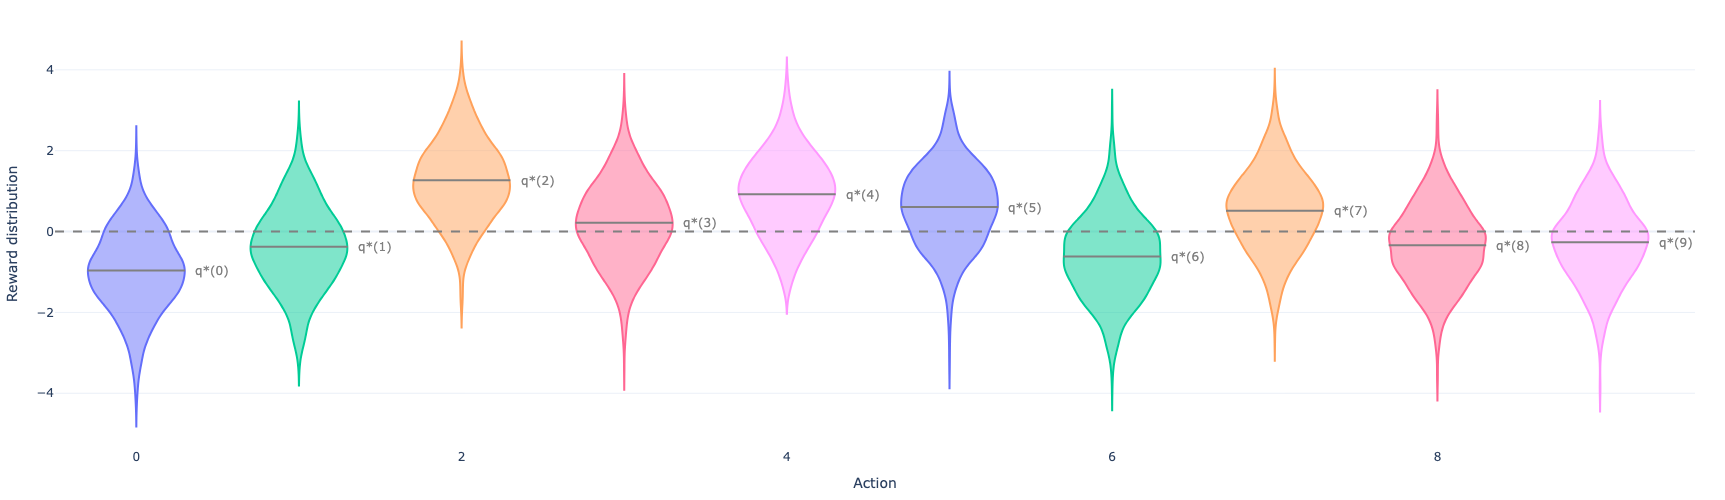

In [6]:
plot_k_armed_bandit_reward_distribution(n_actions=N_ACTIONS, n_steps=N_STEPS, seed=SEED)

## 2. Action-Value Methods

### 2.1. Sampling Average Methods

Action-Value methods estimates action values in order to make action selection decisions. Recall that the true value of an action is the mean reward when that action is selected:

$$
Q_t(a) \; \dot{=} \; \frac{\text{sum of rewards when $a$ taken prior to $t$}}{\text{number of times $a$ taken prior to $t$}} \; 
= \; \frac{\sum_{i = 1}^{t - 1} R_i \cdot \mathbb{I}_{A_i = a}}{\sum_{i = 1}^{t - 1} \mathbb{I}_{A_i = a}},
$$

where $\mathbb{I}_{predicate}$ denotes the random variable that is $1$ if predicate is true and $0$ if it is not. If the denominator is zero, then we instead define $Q_t(a)$ as some default value, such as $0$. As the denominator goes to infinity, by the law of large numbers, $Q_t(a)$ converges to $q_*(a)$. We call this the **sample-average method** for estimating action values because each estimate is an average of the sample of relevant rewards.

#### 2.1.1. Greedy Action Selection

Now that we have estimated the action values, the simplest action selection rule is to select one of the actions with the highest estimated value (**greedy action selection**). If there is more than one greedy action, then a selection is made among them in some arbitrary way, perhaps randomly. We write this greedy action selection method as:

$$
A_t = \arg{\max_{a}(Q_t(a))},
$$

where $\arg{\max_{a}}$ denotes the action $a$ for which the expression that follows is maximized (again, with ties broken arbitrarily). Greedy action selection always exploits the action maximizing $Q_t(a)$ (breaking ties arbitrarily) to exploit current estimates for immediate reward, ignoring potential better alternatives.

#### 2.1.2. $\varepsilon$-Greedy Action Selection

Let's introduce **$\varepsilon$-greedy action selection**, a near-greedy action selection rule where most of the time, we behave greedily, but once in a while, say with a small probability $\varepsilon$, we randomly choose among all actions with equal probability, independently of the action-value estimates.  An advantage of this method is that, in the limit as the number of steps increases, every action will be sampled an infinite number of times, thus ensuring that all the $Q_t(a)$ converge to $q_*(a)$.

**Note:** In $\varepsilon$-greedy action selection, as the number of steps approaches infinity, the action-value estimates $Q_t(a)$ converge to the true values $q_*(a)$, so the greedy choice becomes the optimal action with probability $1$. The overall probability of selecting the optimal action then becomes:
- With probability $1 - \varepsilon$: Select the greedy (optimal) action, contributing $1 - \varepsilon$.
- With probability $\varepsilon$: Select randomly among all $k$ actions (assuming $k \geq 2$), so the chance of picking the optimal one is $\varepsilon / k$.

Thus, the total probability is $1 - \varepsilon + \varepsilon / k$, which is strictly greater than $1 - \varepsilon$ (since $\varepsilon / k > 0$). This holds asymptotically, approaching **near certainty** as $\varepsilon$ is small, but the exact limit depends on $k$.


#### 2.1.3. Incremental Implementation

Action-value estimates as sample average of rewards requires storing all rewards and recomputing the sum each time, leading to growing memory and computational demands as $t$ increases. Let $R_i$ now denote the reward received after the $i^{th}$ selection of this action, and let $Q_n$ denote the estimate of its action value after it has been selected $n - 1$ times, which we can now write simply as:

$$
Q_n \; \doteq \; \frac{R_1 + R_2 + \cdots + R_{n - 1}}{n - 1}
$$

The obvious implementation would be to maintain a record of all the rewards and then perform this computation whenever the estimated value was needed. Each additional reward would require additional memory to store it and additional computation to compute the sum in the numerator.  It is easy to devise incremental formulas for updating averages with small, constant computation required to process each new reward. Given $Q_n$ and the $n_{th}$ reward, $R_n$, the new average of all $n$ rewards can be computed by:

$$
\begin{aligned}
Q_{n + 1} &= \frac{1}{n} \sum_{i = 1}^{n} R_i  \\  \\
&= \frac{1}{n} \Bigg(R_n + \sum_{i = 1}^{n - 1} R_i \Bigg) \\  \\
&= \frac{1}{n} \Bigg(R_n + (n - 1) \frac{1}{n - 1} \sum_{i = 1}^{n - 1} R_i \Bigg) \\  \\
&= \frac{1}{n} \Big(R_n + (n - 1) Q_n \Big) \\  \\
&= \frac{1}{n} \Big(R_n + n Q_n - Q_n  \Big) \\  \\
&= Q_n + \frac{1}{n} \Big[ R_n - Q_n \Big],
\end{aligned}
$$

which holds even for $n = 1$, obtaining $Q_2 = R_1$ for arbitrary $Q_1$. This implementation requires memory only for $Q_n$ and $n$, and only a small computation for each new reward. The general form of the imcremental implementation is:

$$
\text{NewEstimate} \leftarrow \text{OldEstimate} + \text{StepSize} \big[ \text{Target} - \text{OldEstimate} \big]
$$
___

In [7]:
%%time
environment = KArmedBanditEnvironment(n_actions=N_ACTIONS, seed=SEED)

agents = [
    KArmedBanditAgent(n_actions=N_ACTIONS, epsilon=0.00, seed=SEED),
    KArmedBanditAgent(n_actions=N_ACTIONS, epsilon=0.01, seed=SEED),
    KArmedBanditAgent(n_actions=N_ACTIONS, epsilon=0.10, seed=SEED),
]


N_RUNS = 2000

experiment = KArmedBanditExperiment(environment=environment, n_runs=N_RUNS, n_steps=N_STEPS)

average_rewards, optimal_action_pct = experiment.start(agents=agents)

Agent-2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:21<00:00, 93.74it/s]


CPU times: user 1min 3s, sys: 14.8 s, total: 1min 18s
Wall time: 1min 5s


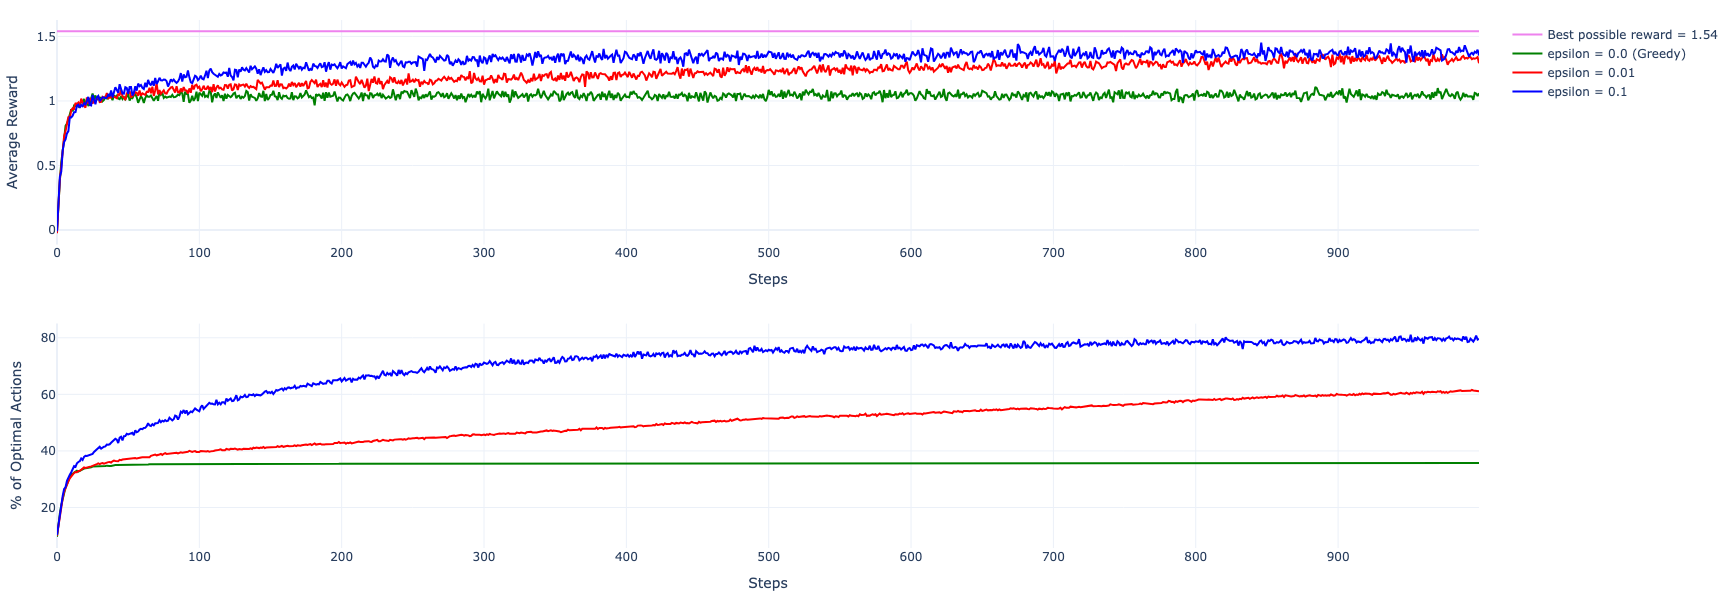

In [8]:
colors = ["green", "red", "blue"]

fig = make_subplots(rows=2, cols=1)

fig.add_trace(trace=go.Scatter(
    y=1.54 + np.zeros(shape=(N_STEPS,)),
    marker=dict(color="violet"),
    name="Best possible reward = 1.54",
), row=1, col=1)

for i, agent in enumerate(agents):
    fig.add_trace(trace=go.Scatter(
        y=average_rewards[i],
        marker=dict(color=colors[i]),
        name=f"epsilon = {agent.epsilon} " + ("(Greedy)" if agent.epsilon == 0.0 else ""),
    ), row=1, col=1)
    
    fig.add_trace(trace=go.Scatter(
        y=optimal_action_pct[i],
        marker=dict(color=colors[i]),
        showlegend=False
    ), row=2, col=1)

fig.update_xaxes(title_text="Steps", row=1, col=1)
fig.update_xaxes(title_text="Steps", row=2, col=1)
fig.update_yaxes(title_text="Average Reward", row=1, col=1)
fig.update_yaxes(title_text="% of Optimal Actions", row=2, col=1)
fig.update_layout(
    template="plotly_white",
    margin=dict(l=50, r=30, t=20, b=40),
    width=1000,
    height=600,
)
fig.show()

- **Greedy Method Performance**
    - Performs poorly in the long run, often stuck with suboptimal actions.
    - Found the optimal action in only about one-third of tasks.
    - Failed in the other two-thirds due to misleading early samples.
- **e-Greedy Methods Performance**
    - Perform better because they continue to explore.
    - $\varepsilon = 0.1$: Explores more, usually finds the optimal action earlier, but selects it at most 81% of the time.
    - $\varepsilon = 0.01$: Improves more slowly but eventually outperforms $\varepsilon = 0.1$ on long-term performance.
- **Effect of Reward Variance**
    - **High variance** (e.g., 10 instead of 1): More exploration is needed, favoring $\varepsilon$-greedy over greedy.
    - **Zero variance**: Greedy may perform best, since it can identify optimal actions quickly without exploration. 